In [18]:
import numpy as np
z = np.load("/home/jovyan/Desktop/PD_LLM/codes/pd&Hc_multi/Fixed_HC_Fused_embeddings/HC_ReadText_fused_embeddings_FIXED.npz", allow_pickle=True)
print(z.files)
for key in z.files:
    print(key, z[key].shape)


['fused', 'ids', 'labels', 'kept_idx']
fused (21, 512)
ids (21,)
labels (21,)
kept_idx (21,)


In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# Load all .npz files
# -------------------------
pd_read_path = "/home/jovyan/Desktop/PD_LLM/codes/pd&Hc_multi/Fixed_PD_Fused_embeddings/PD_ReadText_fused_embeddings_FIXED.npz"
pd_spont_path = "/home/jovyan/Desktop/PD_LLM/codes/pd&Hc_multi/Fixed_PD_Fused_embeddings/PD_Spontaneous_fused_embeddings_FIXED.npz"
hc_read_path = "/home/jovyan/Desktop/PD_LLM/codes/pd&Hc_multi/Fixed_HC_Fused_embeddings/HC_ReadText_fused_embeddings_FIXED.npz"
hc_spont_path = "/home/jovyan/Desktop/PD_LLM/codes/pd&Hc_multi/Fixed_HC_Fused_embeddings/HC_Spontaneous_fused_embeddings_FIXED.npz"

def load_npz(path, label_value):
    z = np.load(path, allow_pickle=True)
    fused = torch.tensor(z["fused"], dtype=torch.float32)
    labels = torch.full((fused.size(0),), label_value, dtype=torch.long)
    ids = z["ids"].astype(str).tolist()
    return fused, labels, ids

# Load both PD and HC sources
pd_fused_r, pd_labels_r, pd_ids_r = load_npz(pd_read_path, 1)
pd_fused_s, pd_labels_s, pd_ids_s = load_npz(pd_spont_path, 1)
hc_fused_r, hc_labels_r, hc_ids_r = load_npz(hc_read_path, 0)
hc_fused_s, hc_labels_s, hc_ids_s = load_npz(hc_spont_path, 0)

# Combine read + spontaneous for each group
pd_fused = torch.cat([pd_fused_r, pd_fused_s], dim=0)
pd_labels = torch.cat([pd_labels_r, pd_labels_s], dim=0)
pd_ids = pd_ids_r + pd_ids_s

hc_fused = torch.cat([hc_fused_r, hc_fused_s], dim=0)
hc_labels = torch.cat([hc_labels_r, hc_labels_s], dim=0)
hc_ids = hc_ids_r + hc_ids_s

# Final combined dataset
fused = torch.cat([hc_fused, pd_fused], dim=0)
labels = torch.cat([hc_labels, pd_labels], dim=0)
ids = hc_ids + pd_ids

print(f"PD fused {pd_fused.shape}, HC fused {hc_fused.shape}, total {fused.shape}")

# -------------------------
# Stratified split
# -------------------------
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    fused.cpu().numpy(),
    labels.cpu().numpy(),
    ids,
    test_size=0.2,
    random_state=42,
    stratify=labels.cpu().numpy(),
)

fused_train = torch.tensor(X_train, dtype=torch.float32).to(device)
fused_val   = torch.tensor(X_val, dtype=torch.float32).to(device)
labels_train = torch.tensor(y_train, dtype=torch.long).to(device)
labels_val   = torch.tensor(y_val, dtype=torch.long).to(device)

print("Train PD:", (labels_train==1).sum().item(), "HC:", (labels_train==0).sum().item())
print("Val   PD:", (labels_val==1).sum().item(), "HC:", (labels_val==0).sum().item())


PD fused torch.Size([31, 512]), HC fused torch.Size([42, 512]), total torch.Size([73, 512])
Train PD: 25 HC: 33
Val   PD: 6 HC: 9


In [22]:
# -------------------
# Fine-tuning Qwen3-4B with feature prefix + LoRA
# -------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    get_linear_schedule_with_warmup, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# -------------------
# Config
# -------------------
model_id = "Qwen/Qwen3-4B-Base"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

batch_size = 16
lr = 3e-4
num_epochs = 5
grad_accum = 2
warmup_ratio = 0.1
num_virtual_tokens = 8
lora_r = 16
lora_alpha = 32
lora_dropout = 0.05
weight_decay = 0.0
LABEL_TOKENS = {0: "HC", 1: "PD"}

# -------------------
# Load Model with 4-bit quantization (new API)
# -------------------
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
    bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=dtype,
    quantization_config=bnb_cfg
)
model = prepare_model_for_kbit_training(model)

# LoRA setup
lora_cfg = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_cfg)

# -------------------
# Feature -> virtual prefix embedding
# -------------------
hidden_size = model.config.hidden_size

class FeaturePrefix(nn.Module):
    def __init__(self, d_in, hidden_size, num_tokens):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_in, 2 * hidden_size),
            nn.SiLU(),
            nn.Linear(2 * hidden_size, num_tokens * hidden_size),
        )
        self.num_tokens = num_tokens
        self.hidden_size = hidden_size

    def forward(self, x):
        y = self.mlp(x)
        return y.view(x.size(0), self.num_tokens, self.hidden_size)

feat_prefix = FeaturePrefix(fused_train.size(1), hidden_size, num_virtual_tokens).to(device)

# -------------------
# Dataset
# -------------------
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

class QwenFeatDataset(torch.utils.data.Dataset):
    def __init__(self, feats, labels):
        self.feats = feats.float().to(device)
        self.labels = labels.long().to(device)
        self.prompt = "You are a medical assistant. Given the hidden patient features, output only 'PD' or 'HC'. Answer:\n"
        self.target_tokens = {k: tokenizer(LABEL_TOKENS[k], add_special_tokens=False).input_ids for k in (0, 1)}

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        x = self.feats[idx]
        y = int(self.labels[idx])
        prompt_ids = tokenizer(self.prompt, add_special_tokens=False).input_ids
        target_ids = self.target_tokens[y]
        return {
            "feat": x,
            "prompt_ids": torch.tensor(prompt_ids, dtype=torch.long),
            "target_ids": torch.tensor(target_ids, dtype=torch.long),
        }

def collate(batch):
    feat = torch.stack([b["feat"] for b in batch]).to(device)
    prompt_ids_list = [b["prompt_ids"] for b in batch]
    target_ids_list = [b["target_ids"] for b in batch]
    prompt_ids = nn.utils.rnn.pad_sequence(prompt_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)
    with torch.no_grad():
        prompt_embeds = model.get_input_embeddings()(prompt_ids.to(device))
    feat_embeds = feat_prefix(feat)
    inputs_embeds = torch.cat([feat_embeds, prompt_embeds], dim=1)
    targets = nn.utils.rnn.pad_sequence(target_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)
    pad_len = inputs_embeds.size(1)
    labels = torch.full((targets.size(0), pad_len), -100, dtype=torch.long, device=device)
    labels = torch.cat([labels, targets.to(device)], dim=1)
    with torch.no_grad():
        target_embeds = model.get_input_embeddings()(targets.to(device))
    inputs_embeds = torch.cat([inputs_embeds, target_embeds], dim=1)
    attention_mask = torch.ones(inputs_embeds.size()[:2], dtype=torch.long, device=device)
    return {"inputs_embeds": inputs_embeds, "labels": labels, "attention_mask": attention_mask}

train_loader = DataLoader(QwenFeatDataset(fused_train, labels_train), batch_size=batch_size, shuffle=True, collate_fn=collate)
val_loader = DataLoader(QwenFeatDataset(fused_val, labels_val), batch_size=batch_size, shuffle=False, collate_fn=collate)

# -------------------
# Optimizer & Scheduler
# -------------------
for p in model.parameters(): p.requires_grad_(False)
for n, p in model.named_parameters():
    if "lora_" in n: p.requires_grad_(True)
for p in feat_prefix.parameters(): p.requires_grad_(True)

optim = torch.optim.AdamW(
    list(p for p in model.parameters() if p.requires_grad) + list(feat_prefix.parameters()),
    lr=lr, weight_decay=weight_decay
)
num_train_steps = num_epochs * math.ceil(len(train_loader) / grad_accum)
sched = get_linear_schedule_with_warmup(optim, int(warmup_ratio * num_train_steps), num_train_steps)
scaler = torch.amp.GradScaler("cuda", enabled=(dtype in (torch.bfloat16, torch.float16)))

# -------------------
# Evaluation helper
# -------------------
def evaluate():
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(**batch)
            logits = out.logits
            labels = batch["labels"]
            first_tgt_pos = (labels != -100).float().argmax(dim=1)
            batch_idx = torch.arange(labels.size(0), device=device)
            pos_logits = logits[batch_idx, first_tgt_pos, :]
            tok_HC = tokenizer(LABEL_TOKENS[0], add_special_tokens=False).input_ids[0]
            tok_PD = tokenizer(LABEL_TOKENS[1], add_special_tokens=False).input_ids[0]
            probs = torch.softmax(pos_logits[:, [tok_HC, tok_PD]], dim=-1)
            preds = probs.argmax(dim=-1).cpu().numpy()
            trues = (labels[batch_idx, first_tgt_pos] == tok_PD).long().cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(trues)
    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    auc = roc_auc_score(all_trues, all_preds) if len(set(all_trues)) > 1 else float('nan')
    cm = confusion_matrix(all_trues, all_preds)
    model.train()
    return acc, prec, rec, f1, auc, cm

# -------------------
# Training Loop
# -------------------
model.train()
global_step = 0
for epoch in range(num_epochs):
    running = 0.0
    for step, batch in enumerate(train_loader):
        with torch.autocast("cuda", dtype=dtype):
            out = model(**batch)
            loss = out.loss / grad_accum
        scaler.scale(loss).backward()
        if (step + 1) % grad_accum == 0:
            scaler.step(optim)
            scaler.update()
            optim.zero_grad(set_to_none=True)
            sched.step()
            global_step += 1
        running += loss.item() * grad_accum
    acc, prec, rec, f1, auc, cm = evaluate()
    print(f"[Epoch {epoch+1}/{num_epochs}] loss={running/len(train_loader):.4f}  acc={acc:.3f}  f1={f1:.3f}  auc={auc:.3f}")
    print("Confusion matrix:\n", cm)

# -------------------
# Save
# -------------------
save_dir = "./qwen_pd_hc_adapter"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
torch.save({
    "state_dict": feat_prefix.state_dict(),
    "config": {"d_in": fused_train.size(1), "hidden_size": hidden_size, "num_virtual_tokens": num_virtual_tokens}
}, os.path.join(save_dir, "feature_prefix.pt"))
tokenizer.save_pretrained(save_dir)
print(f"✅ Model + prefix saved to {save_dir}")


Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]
/home/jovyan/anaconda3/envs/unsloth/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[Epoch 1/5] loss=2.4628  acc=0.600  f1=0.000  auc=0.500
Confusion matrix:
 [[9 0]
 [6 0]]


/home/jovyan/anaconda3/envs/unsloth/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[Epoch 2/5] loss=0.6683  acc=0.267  f1=0.000  auc=0.222
Confusion matrix:
 [[4 5]
 [6 0]]


/home/jovyan/anaconda3/envs/unsloth/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[Epoch 3/5] loss=0.2734  acc=0.600  f1=0.000  auc=0.500
Confusion matrix:
 [[9 0]
 [6 0]]


/home/jovyan/anaconda3/envs/unsloth/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[Epoch 4/5] loss=0.0621  acc=0.733  f1=0.500  auc=0.667
Confusion matrix:
 [[9 0]
 [4 2]]


/home/jovyan/anaconda3/envs/unsloth/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[Epoch 5/5] loss=0.0087  acc=0.733  f1=0.500  auc=0.667
Confusion matrix:
 [[9 0]
 [4 2]]
✅ Model + prefix saved to ./qwen_pd_hc_adapter


Confusion matrix (rows=true [HC,PD], cols=pred [HC,PD]):
 [[9 0]
 [4 2]]

Classification report:
               precision    recall  f1-score   support

          HC       0.69      1.00      0.82         9
          PD       1.00      0.33      0.50         6

    accuracy                           0.73        15
   macro avg       0.85      0.67      0.66        15
weighted avg       0.82      0.73      0.69        15

Accuracy : 0.7333
Precision: 1.0000
Recall   : 0.3333
F1-score : 0.5000
AUC      : 1.0000


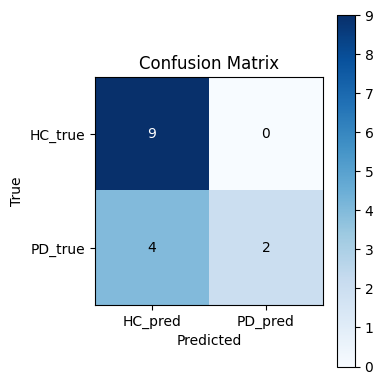

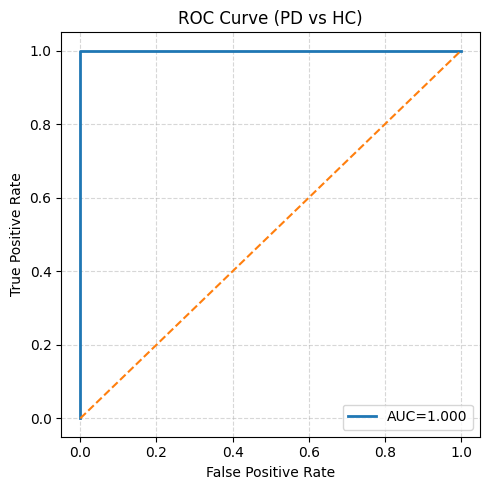

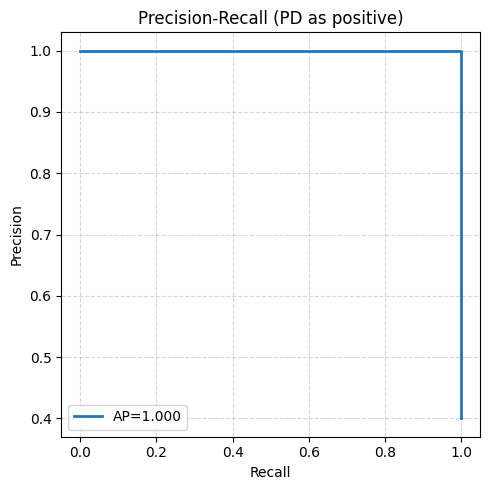

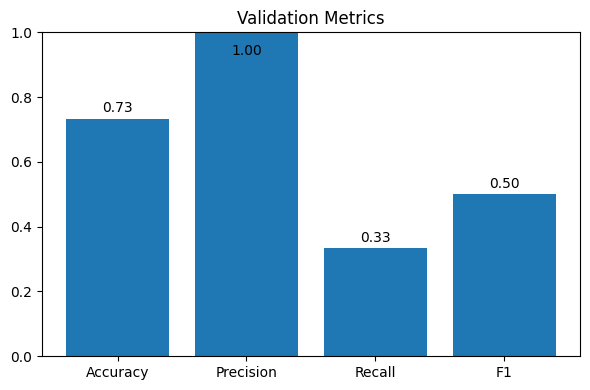

In [24]:
# === Evaluate & Plot (run AFTER training) ===
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, classification_report
)
import matplotlib.pyplot as plt

# ------------- helpers -------------
def get_val_predictions(model, tokenizer, val_loader, label_tokens=("HC","PD")):
    model.eval()
    all_true, all_pred, all_scores = [], [], []
    tok_HC = tokenizer(label_tokens[0], add_special_tokens=False).input_ids[0]
    tok_PD = tokenizer(label_tokens[1], add_special_tokens=False).input_ids[0]

    with torch.no_grad():
        for batch in val_loader:
            out = model(**batch)
            logits = out.logits                          # [B, T, V]
            labels = batch["labels"]                    # [B, T]
            # first supervised position per row
            first_tgt_pos = (labels != -100).float().argmax(dim=1)
            idx = torch.arange(labels.size(0), device=logits.device)
            pos_logits = logits[idx, first_tgt_pos, :]  # [B, V]
            probs = torch.softmax(pos_logits[:, [tok_HC, tok_PD]], dim=-1)
            score_PD = probs[:, 1].detach().cpu().numpy()         # PD probability
            pred = (score_PD >= 0.5).astype(int)                   # threshold 0.5
            true = (labels[idx, first_tgt_pos] == tok_PD).long().cpu().numpy()

            all_true.append(true)
            all_pred.append(pred)
            all_scores.append(score_PD)

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    y_score = np.concatenate(all_scores)
    model.train()
    return y_true, y_pred, y_score

# ------------- compute metrics -------------
y_true, y_pred, y_score = get_val_predictions(model, tokenizer, val_loader, label_tokens=("HC","PD"))

cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
try:
    auc = roc_auc_score(y_true, y_score)
except ValueError:
    auc = float("nan")

print("Confusion matrix (rows=true [HC,PD], cols=pred [HC,PD]):\n", cm)
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=["HC","PD"]))
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ------------- plot each graph individually -------------

# (1) Confusion matrix heatmap
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["HC_pred","PD_pred"])
plt.yticks([0,1], ["HC_true","PD_true"])

# ✅ Corrected iteration
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, str(cm[i, j]), ha="center", va="center", 
             color="white" if cm[i,j] > cm.max()/2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


# (2) ROC Curve
from sklearn.metrics import roc_curve
if len(np.unique(y_true)) > 1:
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (PD vs HC)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# (3) Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
if len(np.unique(y_true)) > 1:
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(5,5))
    plt.plot(r, p, linewidth=2, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (PD as positive)")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# (4) Bar chart of final metrics
plt.figure(figsize=(6,4))
names = ["Accuracy","Precision","Recall","F1"]
vals  = [acc, prec, rec, f1]
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), names)
plt.ylim(0,1)
plt.title("Validation Metrics")
for i,v in enumerate(vals):
    plt.text(i, v+0.02 if v<0.95 else v-0.07, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()
